# Постановка задачи

Выявить влияние продуктов на продолжительность жизни

**Данные:**

**Ожидаемая продолжительность жизни при рождении (ЕМИСС):**

https://www.fedstat.ru/indicator/31293

**Потребление основных продуктов питания (Росстат):**

https://rosstat.gov.ru/compendium/document/13278


**Социально-экономические, демографические, здравоохрание:**

https://tochno.st/datasets/regions_collection

**Экология:**

https://tochno.st/datasets/air_cities


# Предобработка данных

Библиотеки

In [ ]:
import pandas as pd

Функции

In [ ]:
def clean_reg(name):
  return name.replace(' ', '').replace('г.', '').replace('–', '').replace('-', '').lower()

def del_reg(df):
  return df.loc[
    (df['region'] != 'Российская Федерация') & # не регион
    (~df['region'].str.contains('округ', case=False)) & # не регион
    (~df['region'].str.contains('Крым', case=False)) & # данные с 2014 года
    (~df['region'].str.contains('Севастополь', case=False))& # данные с 2014 года
    (~df['region'].str.contains('Чеченская и Ингушская', case=False)) & # неполнные данные
    (~df['region'].str.contains('Костромская', case=False)) & # неполнные данные
    (~df['region'].str.contains('Томская', case=False)) # неполнные данные
    ].drop_duplicates(subset=['region'], keep='first').reset_index(drop=True)

Загружаем и фильтруем Y - ожидаемую продолжительность жизни

In [ ]:
df_y = pd.read_excel('data.xls', header = 2)
df_y.columns = ['region', 'gender', 'category', 'type'] + list(df_y.columns[4:])

df_y = df_y[(df_y['gender'] == 'Оба пола') & (df_y['category'] == 'все население')] # Фильтрация
df_y = df_y[['region'] + [str(year) for year in range(2011, 2022)]] # Оставляем только нужные нам даты и названия регионов
df_y = df_y = df_y.reset_index(drop=True) # Сброс индексов

Загружаем Иксы: потребление продуктов питания

In [ ]:
xls = pd.ExcelFile('Potreb_Svod_2011-2021.xlsx')

dfs_x = {}
for sheet_name in xls.sheet_names[1:]:  # Начинаем с индекса 1, чтобы пропустить первый лист "содержание"
    df = pd.read_excel(xls, sheet_name=sheet_name, header=4)  # Читаем данные с заголовком на 4-й строке
    df.columns = ['region'] + list(df.columns[1:])
    dfs_x[sheet_name] = df  # Сохраняем DataFrame в словаре по имени листа

Чистим названия регионов у Y (они не совпдают с названиями регионов у Иксов)

In [ ]:
for region in dfs_x['мясо'].region.unique():
  for i in range(len(df_y)):
    if clean_reg(region) in clean_reg(df_y.loc[i, 'region']):
      df_y.at[i, 'region'] = region

Объединяем датасеты в один

In [ ]:
df = del_reg(df_y)
df = pd.melt(df, id_vars=['region'], var_name='year', value_name='y')
df['year'] = df['year'].astype(int)

k = 0
x_names = ''
for name, df_x in dfs_x.items():
    k += 1
    line = f"Фактор: {name}, название: x{k}"
    x_names += line + '\n'
    print(line)
    df_x = del_reg(df_x[:91])
    df_x = pd.melt(df_x, id_vars=['region'], var_name='year', value_name='x'+str(k))
    df = pd.merge(df, df_x, on=['region', 'year'], how='outer')

Фактор: мясо, название: x1
Фактор: молоко, название: x2
Фактор: яйца, название: x3
Фактор: картофель, название: x4
Фактор: овощи, название: x5
Фактор: фрукты, название: x6
Фактор: хлебные, название: x7
Фактор: масло раст, название: x8
Фактор: сахар, название: x9


Проверка пустых значений

In [ ]:
df.isnull().sum()

,0
region,0
year,0
y,0
x1,0
x2,0
x3,0
x4,0
x5,0
x6,0
x7,0


Проверка типизации

In [ ]:
df.dtypes

,0
region,object
year,object
y,object
x1,int64
x2,int64
x3,int64
x4,float64
x5,float64
x6,float64
x7,int64


In [ ]:
df['year'], df['y'] = df['year'].astype(int), df['y'].astype(float) # стобцы year и y сделаем int и float соответственно

Получившийся датасет

In [ ]:
df

,region,year,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,Алтайский край,2011,68.94,65,323,307,117.0,90.0,50.0,169,12.8,40.0
1,Алтайский край,2012,69.01,69,320,309,116.0,87.0,51.0,168,13.6,38.0
2,Алтайский край,2013,69.60,69,318,310,112.0,85.0,55.0,168,13.9,39.0
3,Алтайский край,2014,69.77,67,304,312,106.0,82.0,55.0,168,14.5,39.0
4,Алтайский край,2015,70.13,62,284,318,98.0,81.0,54.0,163,14.3,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
842,г. Санкт-Петербург,2017,75.48,71,297,317,67.0,82.0,59.0,85,11.0,36.0
843,г. Санкт-Петербург,2018,75.97,71,289,319,63.0,82.0,58.0,82,10.8,36.0
844,г. Санкт-Петербург,2019,76.38,70,288,322,62.0,83.0,60.0,83,10.8,36.0
845,г. Санкт-Петербург,2020,74.23,71,300,335,60.0,83.0,58.0,83,10.8,36.0


In [ ]:
len(df.region.unique())

77

In [ ]:
df.region.unique()

array(['Алтайский край', 'Амурская область', 'Архангельская область',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Владимирская область', 'Волгоградская область',
       'Вологодская область', 'Воронежская область',
       'Еврейская автономная область', 'Забайкальский край',
       'Ивановская область', 'Иркутская область',
       'Кабардино-Балкарская Республика', 'Калининградская область',
       'Калужская область', 'Камчатский край',
       'Карачаево-Черкесская Республика', 'Кемеровская область – Кузбасс',
       'Кировская область', 'Краснодарский край', 'Красноярский край',
       'Курганская область', 'Курская область', 'Ленинградская область',
       'Липецкая область', 'Магаданская область', 'Московская область',
       'Мурманская область', 'Нижегородская область',
       'Новгородская область', 'Новосибирская область', 'Омская область',
       'Оренбургская область', 'Орловская область', 'Пензенская область',
       'Пермский край', 'П

# Корреляционный анализ

Задача

Библиотеки

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Корреляция

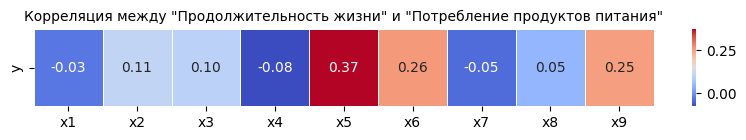

In [ ]:
df_corr = df.drop(columns=['region', 'year'])

correlation_matrix = df_corr.corr()

y_corr = correlation_matrix.loc['y', 'x1':'x9']

plt.figure(figsize=(10, 1))
sns.heatmap(y_corr.to_frame().T, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляция между "Продолжительность жизни" и "Потребление продуктов питания"', fontsize=10)
plt.show()

Обозначения

In [ ]:
print(x_names)

Фактор: мясо, название: x1
Фактор: молоко, название: x2
Фактор: яйца, название: x3
Фактор: картофель, название: x4
Фактор: овощи, название: x5
Фактор: фрукты, название: x6
Фактор: хлебные, название: x7
Фактор: масло раст, название: x8
Фактор: сахар, название: x9



# Линейная регрессия

Задача

Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Модель

In [ ]:
# Определяем X и y
X = df.drop(columns=['region', 'year', 'y'])
y = df['y']

# Добавляем константу (для свободного члена) к X
X = sm.add_constant(X)

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Создаем модель линейной регрессии
model = sm.OLS(y_train, X_train).fit()

# Получаем предсказания
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Анализ коэффициентов регрессии
print("\nКоэффициенты регрессии:")
print(model.params)
print("\nРезультаты модели:")
print(model.summary())

Mean Squared Error: 4.794395324933471
R-squared: 0.2154569495368862

Коэффициенты регрессии:
const    67.167601
x1       -0.008857
x2        0.005347
x3       -0.001060
x4       -0.009535
x5        0.028789
x6        0.006982
x7       -0.016040
x8       -0.018101
x9        0.075053
dtype: float64

Результаты модели:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     18.01
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           6.35e-27
Time:                        14:46:01   Log-Likelihood:                -1527.4
No. Observations:                 677   AIC:                             3075.
Df Residuals:                     667   BIC:                             3120.
Df Model:                           9             

# Линейная регрессия без Covid-19

Всемирная пандемия могла резко сократить ожидаемую продолжительность жизни. Посмотрим на модель без учета данных 2019-2021 годов.

In [ ]:
df_covid = df.copy()
df_covid = df_covid[df_covid['year'].isin(range(2011, 2019))]

In [ ]:
# Определяем X и y
X = df_covid.drop(columns=['region', 'year', 'y'])
y = df_covid['y']

# Добавляем константу (для свободного члена) к X
X = sm.add_constant(X)

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем модель линейной регрессии
model = sm.OLS(y_train, X_train).fit()

# Получаем предсказания
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Анализ коэффициентов регрессии
print("\nКоэффициенты регрессии:")
print(model.params)
print("\nРезультаты модели:")
print(model.summary())

Mean Squared Error: 5.093299836519363
R-squared: 0.19481107112596818

Коэффициенты регрессии:
const    66.377375
x1       -0.008233
x2        0.004838
x3       -0.001135
x4       -0.005386
x5        0.030812
x6        0.004941
x7       -0.012147
x8       -0.010061
x9        0.070568
dtype: float64

Результаты модели:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     13.37
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           3.44e-19
Time:                        14:46:02   Log-Likelihood:                -1109.6
No. Observations:                 492   AIC:                             2239.
Df Residuals:                     482   BIC:                             2281.
Df Model:                           9            

# Lagged model

Потребление продуктов в одном году может повляить на ожидаемую продолжительность жизни в последующие годы

In [ ]:
df_shift1 = df.copy()
df_shift1['y_shifted1'] = df_shift1.groupby('region')['y'].shift(-1) # сдвигаем y на 1 год назад
df_shift1 = df_shift1.dropna()

In [ ]:
df_shift2 = df.copy()
df_shift2['y_shifted2'] = df_shift2.groupby('region')['y'].shift(-2) # сдвигаем y на 2 года назада
df_shift2 = df_shift2.dropna()

Модель на следующий год

In [ ]:
# Определяем X и y
X = df_shift1.drop(columns=['region', 'year', 'y', 'y_shifted1'])
y = df_shift1['y_shifted1']

# Добавляем константу (для свободного члена) к X
X = sm.add_constant(X)

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем модель линейной регрессии
model = sm.OLS(y_train, X_train).fit()

# Получаем предсказания
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Анализ коэффициентов регрессии
print("\nКоэффициенты регрессии:")
print(model.params)
print("\nРезультаты модели:")
print(model.summary())

Mean Squared Error: 6.029912464715596
R-squared: 0.15720780339367213

Коэффициенты регрессии:
const    67.834367
x1       -0.016390
x2        0.005352
x3        0.001873
x4       -0.006045
x5        0.027096
x6        0.007325
x7       -0.017053
x8       -0.078841
x9        0.073163
dtype: float64

Результаты модели:
                            OLS Regression Results                            
Dep. Variable:             y_shifted1   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     16.20
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           6.14e-24
Time:                        14:46:02   Log-Likelihood:                -1360.4
No. Observations:                 616   AIC:                             2741.
Df Residuals:                     606   BIC:                             2785.
Df Model:                           9            

Модель через 2 года

In [ ]:
# Определяем X и y
X = df_shift2.drop(columns=['region', 'year', 'y', 'y_shifted2'])
y = df_shift2['y_shifted2']

# Добавляем константу (для свободного члена) к X
X = sm.add_constant(X)

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем модель линейной регрессии
model = sm.OLS(y_train, X_train).fit()

# Получаем предсказания
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Анализ коэффициентов регрессии
print("\nКоэффициенты регрессии:")
print(model.params)
print("\nРезультаты модели:")
print(model.summary())

Mean Squared Error: 4.827356755884781
R-squared: 0.15665157652668793

Коэффициенты регрессии:
const    68.117612
x1       -0.016971
x2        0.005048
x3       -0.002081
x4       -0.006716
x5        0.026301
x6        0.006375
x7       -0.009540
x8       -0.043215
x9        0.070509
dtype: float64

Результаты модели:
                            OLS Regression Results                            
Dep. Variable:             y_shifted2   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     14.25
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           9.31e-21
Time:                        14:46:02   Log-Likelihood:                -1230.0
No. Observations:                 554   AIC:                             2480.
Df Residuals:                     544   BIC:                             2523.
Df Model:                           9            

# Модель отклонений от нормы

Возможно, не совсем правильно было оставлять потребление продуктов питания не обработав значения, сопаставив их с рекомендуемыми. Ведь в реальности не работает логика: "чем больше овощей ешь - тем лучше". Есть еще рекомендуемая норма, превышение которой также ухудшит ситуацию. Попробуем построить модель отталкиваясь от "РЕКОМЕНДУЕМЫЕ РАЦИОНАЛЬНЫЕ НОРМЫ ПОТРЕБЛЕНИЯ ПИЩЕВЫХ ПРОДУКТОВ, ОТВЕЧАЮЩИХ СОВРЕМЕННЫМ ТРЕБОВАНИЯМ ЗДОРОВОГО ПИТАНИЯ" Минздрав

https://37fbuz.ru/o-tsentre/rekomendatsii-grazhdanam/746-rekomenduemye-ratsionalnye-normy-potrebleniya-pishchevykh-produktov-otvechayushchikh-sovremennym-trebovaniyam-zdorovogo-pitaniya

Рекомендованное кол-во потребления продукта кг/год/человек (Минздрав)
*   x1: мясо, норма: 73
*   x2: молоко, норма: 325
*   x3: яйца, норма: 260 (штук)
*   x4: картофель, норма: 90
*   x5: овощи, норма: 140
*   x6: фрукты, норма: 100
*   x7: хлебные, норма: 96
*   x8: масло раст, норма: 12
*   x9: сахар, норма: 24





In [ ]:
norms = {'x1': 73, 'x2': 325, 'x3': 260, 'x4': 90, 'x5': 140, 'x6': 100, 'x7': 96, 'x8': 12, 'x9': 24}

In [ ]:
df_norm = df.copy()
df_norm.head()

,region,year,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,Алтайский край,2011,68.94,65,323,307,117.0,90.0,50.0,169,12.8,40.0
1,Алтайский край,2012,69.01,69,320,309,116.0,87.0,51.0,168,13.6,38.0
2,Алтайский край,2013,69.60,69,318,310,112.0,85.0,55.0,168,13.9,39.0
3,Алтайский край,2014,69.77,67,304,312,106.0,82.0,55.0,168,14.5,39.0
4,Алтайский край,2015,70.13,62,284,318,98.0,81.0,54.0,163,14.3,38.0


In [ ]:
x_labels = df_norm.columns[3:]
for x in x_labels:
  df_norm[x] = df_norm[x] - norms[x]

In [ ]:
df_norm.head()

,region,year,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,Алтайский край,2011,68.94,-8,-2,47,27.0,-50.0,-50.0,73,0.8,16.0
1,Алтайский край,2012,69.01,-4,-5,49,26.0,-53.0,-49.0,72,1.6,14.0
2,Алтайский край,2013,69.60,-4,-7,50,22.0,-55.0,-45.0,72,1.9,15.0
3,Алтайский край,2014,69.77,-6,-21,52,16.0,-58.0,-45.0,72,2.5,15.0
4,Алтайский край,2015,70.13,-11,-41,58,8.0,-59.0,-46.0,67,2.3,14.0


Модель

In [ ]:
# Определяем X и y
X = df_norm.drop(columns=['region', 'year', 'y'])
y = df_norm['y']

# Добавляем константу (для свободного члена) к X
X = sm.add_constant(X)

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Создаем модель линейной регрессии
model = sm.OLS(y_train, X_train).fit()

# Получаем предсказания
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Анализ коэффициентов регрессии
print("\nКоэффициенты регрессии:")
print(model.params)
print("\nРезультаты модели:")
print(model.summary())

Mean Squared Error: 4.79439532493337
R-squared: 0.21545694953690286

Коэффициенты регрессии:
const    71.898117
x1       -0.008857
x2        0.005347
x3       -0.001060
x4       -0.009535
x5        0.028789
x6        0.006982
x7       -0.016040
x8       -0.018101
x9        0.075053
dtype: float64

Результаты модели:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     18.01
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           6.35e-27
Time:                        14:49:18   Log-Likelihood:                -1527.4
No. Observations:                 677   AIC:                             3075.
Df Residuals:                     667   BIC:                             3120.
Df Model:                           9             

тоже самое, но с модулем

In [ ]:
df_norm_abs = df.copy()
x_labels = df_norm_abs.columns[3:]
for x in x_labels:
  df_norm_abs[x] = abs(df_norm_abs[x] - norms[x])

In [ ]:
# Определяем X и y
X = df_norm_abs.drop(columns=['region', 'year', 'y'])
y = df_norm_abs['y']

# Добавляем константу (для свободного члена) к X
X = sm.add_constant(X)

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Создаем модель линейной регрессии
model = sm.OLS(y_train, X_train).fit()

# Получаем предсказания
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выводим результаты
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Анализ коэффициентов регрессии
print("\nКоэффициенты регрессии:")
print(model.params)
print("\nРезультаты модели:")
print(model.summary())

Mean Squared Error: 5.074944037715702
R-squared: 0.16954864869548125

Коэффициенты регрессии:
const    71.207575
x1        0.060993
x2       -0.005163
x3        0.002304
x4        0.005834
x5       -0.003536
x6       -0.040073
x7       -0.011461
x8        0.171509
x9        0.067522
dtype: float64

Результаты модели:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     13.72
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           2.35e-20
Time:                        14:49:39   Log-Likelihood:                -1543.5
No. Observations:                 677   AIC:                             3107.
Df Residuals:                     667   BIC:                             3152.
Df Model:                           9            

Модель, построенная на основе данных о потреблении различных групп продуктов, объясняет примерно 20% вариации в ожидаемой продолжительности жизни регионов РФ. Это свидетельствует о статистически значимой связи между пищевыми факторами и продолжительностью жизни. Однако следует отметить, что оставшиеся 80% вариаций обусловлены другими факторами, не включёнными в модель, а также случайными вариациями. Доверительные интервалы для коэффициентов (например, для потребления овощей и сахара) подтверждают значимость влияния отдельных пищевых групп на ожидаемую продолжительность жизни.